# Генерация и отбор признаков

In [53]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 75)

from datetime import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
import tsfresh
from tsfresh.utilities.dataframe_functions import make_forecasting_frame, impute
from tsfresh import extract_features, select_features

from sklearn.feature_selection import mutual_info_regression

In [2]:
dataset_per_week = pd.read_csv('../data/processed/dataset_per_week.csv', parse_dates=True, index_col=0)
dataset_per_week.shape

(334, 63)

In [3]:
dataset_per_week.drop(columns=['target_1', 'target_2', 'target_3', 'target_4'], inplace=True)

## Ручная генерация признаков и их отбор через анализ корреляции Пирсона/Спирмена

In [ ]:
# Код для ручной генерации признаков использовался прежде, чем использовать библиотеку tsfresh

# for j in list_of_columns:
#     for i in ['mean_4', 'mean_9', 'mean_13', 'mean_26', 'mean_52']:
#         dataset_per_week[j+'_'+i] = dataset_per_week[j].rolling(int(i.split('_')[-1]), min_periods=1).mean()
#     for i in ['shift_1', 'shift_2', 'shift_4', 'shift_9', 'shift_13']:
#         dataset_per_week[j+'_'+i] = dataset_per_week[j].shift(int(i.split('_')[-1]))
#     for i in ['std_4', 'std_9', 'std_13', 'std_26']:
#         dataset_per_week[j+'_'+i] = dataset_per_week[j].rolling(int(i.split('_')[-1]), min_periods=1).std()
#     for i in [1,2,4,9,13]:
#         dataset_per_week[j+'_increment_by_shift_'+str(i)] = dataset_per_week[j]-dataset_per_week[j+'_shift_'+str(i)]
#     for i in [4,9,13,26]:
#         dataset_per_week[j+'_increment_by_mean_'+str(i)] = dataset_per_week[j]-dataset_per_week[j+'_mean_'+str(i)]

# dataset_per_week.shape
# sns.heatmap(dataset_per_week.isna())

# # Отрежем вверх
# dataset_per_week = dataset_per_week.iloc[13:]
# # Отбросим плохие колонки
# cols = dataset_per_week.isna().sum()[dataset_per_week.isna().sum()>0].index.values.copy()
# dataset_per_week = dataset_per_week.drop(columns=cols)

In [ ]:
# Код для ручной селекции признаков использовался прежде, чем использовать библиотеку tsfresh

# dataset_per_week.columns
# candidates = dataset_per_week.corr(method='spearman').lme_price_smooth.sort_values()[-600:]
# candidates = candidates.sort_values(ascending=False).index.values
# candidates

# correlation_matrix = dataset_per_week[candidates].corr(method='spearman')
# correlation_matrix
# candidates = candidates[1:]


# def select(candidates, corr_matrix):
#     features = list(candidates.copy())
#     l = len(candidates)
#     for i in range(l):
#         for j in range(i+1,l):
#             if corr_matrix[candidates[i]][candidates[j]]>0.75:
#                 if corr_matrix['lme_price_smooth'][candidates[i]] > corr_matrix['lme_price_smooth'][candidates[j]]:
#                     try:
#                         features.remove(candidates[j])
#                     except:
#                         pass
#                 else:
#                     try:
#                         features.remove(candidates[i])
#                     except:
#                         pass
#     return features

# features = select(candidates=candidates, corr_matrix=correlation_matrix)
# len(features)

# dataset_per_week['target_1'] = dataset_per_week.lme_price_smooth.diff(periods=1)
# dataset_per_week['target_2'] = dataset_per_week.lme_price_smooth.diff(periods=2)
# dataset_per_week['target_3'] = dataset_per_week.lme_price_smooth.diff(periods=3)
# dataset_per_week['target_4'] = dataset_per_week.lme_price_smooth.diff(periods=4)
# features.extend(["covid", "after_feb", "lme_price_smooth", "target_1", "target_2", "target_3", "target_4"])
# final_df = dataset_per_week[features]

## Библиотека TSfresh, генерация признаков

In [4]:
y = dataset_per_week[['lme_price_smooth']].copy()
y["lme_price_smooth"] = y.lme_price_smooth.shift(-4)
# отбор признаков происходит, ориентируясь на смещенный таргет с помощью "select features"
y = y[1:-4] # слайс с 1, так как после обработки данных алгоритмами из библиотеки tsfresh возникнет смещение на 1 дату
y = y.lme_price_smooth # переход к pd.Series

Нижеприведенный код осуществляет генерацию и селекцию признаков по анализу прошедших 2, 4, 9, 12 недель относительно текущей даты

In [5]:
print(dataset_per_week.index.min().strftime("%Y-%m-%d"))
print(dataset_per_week.index.max().strftime("%Y-%m-%d"))

2018-01-07
2024-05-26


In [6]:
def ts_fresh_features(dataset: pd.DataFrame) -> pd.DataFrame:
    cnt = 0
    
    extracted_relevant_features = pd.DataFrame(index=pd.date_range(start=dataset.index.min().strftime("%Y-%m-%d"), 
                                                                   end=dataset.index.max().strftime("%Y-%m-%d"), 
                                                                   freq='W'))
    extracted_relevant_features.index.name = 'date' # создание фрейма с индексом 'date'
    list_of_columns = dataset.columns.values.copy()
    for i in list_of_columns: # перебор по названиям экзогенных признаков
        cnt += 1
        for k in [2,4,9,12]: # перебор по 2, 4, 9, 12 неделям
            series = dataset[i].copy() # срез по определенному экзогенному признаку
            df_rolled = make_forecasting_frame(series, kind='price', max_timeshift=k, rolling_direction=1) # генерация временных рядов 
            df_features = extract_features(df_rolled[0].drop(columns=['kind']), column_id="id", column_sort="time") # генерация признаков
            suf = '_'+i+'_'+str(k)+'_weeks' 
            df_features = df_features.add_suffix(suf) # название колонок по признаку и окну 2, 4, 9, 12
            df_features.reset_index(inplace=True)
            df_features.drop(columns=['level_0'], inplace=True)
            df_features.rename(columns={'level_1': 'date'}, inplace=True) 
            df_features.set_index('date', inplace=True) # сброс мультииндекса и назначение нового
            df_features = df_features.dropna(axis=1) # сброс всех колонок с Nan
            df_features = df_features[:-4] # срез последних 4 точек, так как таргет смещен на 4 (прогноз на месяц вперед)
            df_selected_features = select_features(df_features, y) # селекция признаков
            extracted_relevant_features = extracted_relevant_features.join(df_selected_features, on='date', how='left') # join
            #print(f"Joined succesfully! Columns count is {extracted_relevant_features.shape[1]}")
            del series
            del df_rolled
            del df_features
            del df_selected_features
        #print("Created features for", i)
        print(f"Осталось {len(list_of_columns) - cnt} признаков")
    return extracted_relevant_features

In [ ]:
extracted_relevant_features = ts_fresh_features(dataset=dataset_per_week)

In [13]:
extracted_relevant_features.dropna(inplace=True)

# Save checkpoint

In [14]:
extracted_relevant_features.to_csv('../data/processed/extracted_relevant_features.csv')

In [5]:
extracted_relevant_features = pd.read_csv('../data/processed/extracted_relevant_features.csv', parse_dates=True, index_col=0)

### Удалим признаки с нулевым среднеквадратичным отклоеннием

In [6]:
print(f"Before: {extracted_relevant_features.shape}")

mask = extracted_relevant_features.std()!=0
extracted_relevant_features = extracted_relevant_features[extracted_relevant_features.std()[mask].index]

print(f"After: {extracted_relevant_features.shape}")

Before: (329, 9357)
After: (329, 9357)


In [16]:
# Очевидно, что это происходило внутри встроенной функции "select_features"

### Объединим нагенерированные признаки с исходными экзогенными признаками и таргетом

In [7]:
extracted_relevant_features = extracted_relevant_features.join(dataset_per_week, on='date', how='left')
extracted_relevant_features.shape

(329, 9416)

### Признаков по-прежнему очень много, попробуем применить Mutual info из Sklearn

In [8]:
y_ = y.values
x_ = extracted_relevant_features.values
feature_names = extracted_relevant_features.columns.to_list()

In [9]:
mi_scores = mutual_info_regression(x_, y_) # Запускаем с дефолтными настройками

In [10]:
threshold = np.quantile(mi_scores, 0.95)
selected_features = np.array(feature_names)[mi_scores > threshold]

print(f"Number of selected features: {len(selected_features)}")

Number of selected features: 471


In [11]:
extracted_relevant_features = extracted_relevant_features.loc[:, selected_features].copy()

In [12]:
extracted_relevant_features['target'] = y.values

In [13]:
# # features and target after variance threshold and mutual info
# extracted_relevant_features.to_csv('../data/processed/data_after_vt_mi.csv')
# extracted_relevant_features = pd.read_csv('../data/processed/features_after_vt_mi.csv', parse_dates=True, index_col=0)

In [14]:
# Введем период после повышения ставки ФРС
extracted_relevant_features['after_feb']=np.where((extracted_relevant_features.index>='2022-03-01')&(extracted_relevant_features.index<='2022-09-01'), 1, 0)

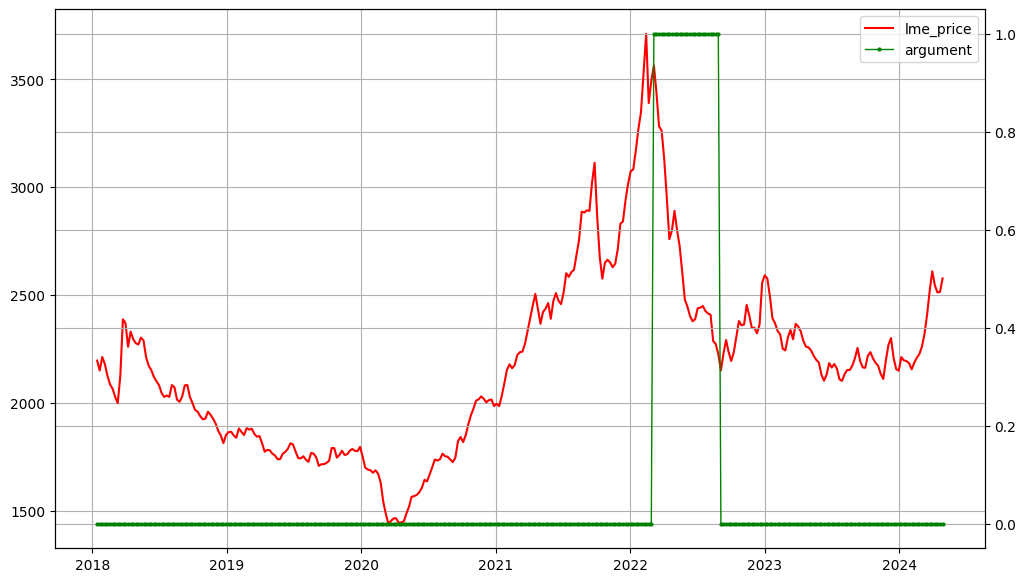

In [15]:
fig, ax = plt.subplots(figsize=(12, 7))
l1, = ax.plot(extracted_relevant_features.index.values, extracted_relevant_features.target.values, color='r')
ax1 = ax.twinx()
l2, = ax1.plot(extracted_relevant_features.index.values, extracted_relevant_features.after_feb, color='g', marker='o', linewidth=1, markersize=2)
ax1.legend([l1,l2],['lme_price', 'argument'])
#ax1.set_ylim([0,1e6])
ax.grid(True)
ax1.grid(True)

## Feature importance

In [16]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

In [17]:
X = extracted_relevant_features.drop(columns=['target']).values
y = extracted_relevant_features['target'].values

X_full_train, X_full_test, y_train, y_test = train_test_split(X, y, test_size=.1, shuffle=False)
X_train, X_valid, y_train, y_valid = train_test_split(X_full_train, y_train, test_size=.1, shuffle=False)

In [18]:
model = CatBoostRegressor(eval_metric = "MAPE",
                          task_type = "CPU",
                          thread_count = 4,
                          random_state=42)

model.fit(X=X_train,
          y=y_train,
          eval_set=(X_valid, y_valid),
          early_stopping_rounds=10)

Learning rate set to 0.041362
0:	learn: 0.1675876	test: 0.0297177	best: 0.0297177 (0)	total: 76.9ms	remaining: 1m 16s
1:	learn: 0.1615858	test: 0.0287414	best: 0.0287414 (1)	total: 92.7ms	remaining: 46.2s
2:	learn: 0.1556104	test: 0.0281907	best: 0.0281907 (2)	total: 108ms	remaining: 36s
3:	learn: 0.1500192	test: 0.0284104	best: 0.0281907 (2)	total: 124ms	remaining: 30.9s
4:	learn: 0.1447417	test: 0.0284756	best: 0.0281907 (2)	total: 140ms	remaining: 27.9s
5:	learn: 0.1396310	test: 0.0280821	best: 0.0280821 (5)	total: 156ms	remaining: 25.8s
6:	learn: 0.1344962	test: 0.0280833	best: 0.0280821 (5)	total: 172ms	remaining: 24.3s
7:	learn: 0.1299487	test: 0.0284889	best: 0.0280821 (5)	total: 187ms	remaining: 23.2s
8:	learn: 0.1255072	test: 0.0298747	best: 0.0280821 (5)	total: 203ms	remaining: 22.4s
9:	learn: 0.1212230	test: 0.0302612	best: 0.0280821 (5)	total: 219ms	remaining: 21.7s
10:	learn: 0.1172600	test: 0.0310568	best: 0.0280821 (5)	total: 236ms	remaining: 21.2s
11:	learn: 0.1131573	t

In [19]:
prediction = model.predict(X_full_test)
print(f"MAPE: {mean_absolute_percentage_error(y_test, prediction):.2f}")

MAPE: 0.04


In [20]:
list_of_features = extracted_relevant_features.drop(columns=['target']).columns.to_list()
importances = model.feature_importances_

df = pd.DataFrame(data={"importances":importances,
                        "feature_names":list_of_features})
df.sort_values(by="importances", ascending=False, inplace=True)
df = df[df.importances > 0]
df.reset_index(drop=True, inplace=True)

In [21]:
df

,importances,feature_names
0,19.545914,value__quantile__q_0.4_peru_consumer_price_ind...
1,9.500899,value__quantile__q_0.6_peru_producer_price_ind...
2,6.825293,value__root_mean_square_lme_price_3features_9_...
3,6.027832,value__quantile__q_0.7_peru_producer_price_ind...
4,5.950635,value__abs_energy_peru_producer_price_index_12...
5,5.338755,value__quantile__q_0.4_lme_price_smooth_2_weeks
6,4.877917,value__mean_lme_price_smooth_9_weeks
7,3.678780,value__quantile__q_0.6_mosexchange_price_12_weeks
8,3.406403,value__minimum_log10_hongqiao_volume_12_weeks
9,3.296273,value__quantile__q_0.6_lme_price_smooth_9_weeks


In [22]:
# Отрезали множество признаков, значимость которых, по мнению модели, была пренебрежимо мала
extracted_relevant_features = extracted_relevant_features.loc[:, df.feature_names]

## Прежде, чем анализировать парную корелляцию, необходимо привести все ряды к стационарному виду (например, продифференцировав все)

In [30]:
diff_relevant_features = extracted_relevant_features.diff(periods=1).copy()
diff_relevant_features = diff_relevant_features[1:]

In [31]:
# Тест Дикки-Фуллера с alpha уровнем значимости
def check_stationarity(ts: list, alpha: float):
    dftest = adfuller(ts)
    adf, pvalue, critical_value = dftest[0], dftest[1], dftest[4]['5%']
    if (pvalue < alpha) and (adf < critical_value):
        #print('The series is stationary')
        return True
    else:
        #print('The series is NOT stationary')
        return False

In [32]:
not_stationary = list()
for i in diff_relevant_features.columns:
    if check_stationarity(diff_relevant_features[i], 0.05) is False:
        not_stationary.append(i)

In [33]:
len(not_stationary)

6

In [34]:
diff_relevant_features.drop(columns=not_stationary, inplace=True)

In [35]:
diff_relevant_features['target'] = y[1:]

Для анализа парной корелляции удобнее создать словарь, в котором ключом выступает признак  
Не забудем удалить признаки, которые оказались нестационарны даже после дифференцирования

In [36]:
key_list = df.feature_names.values
value_list = df.importances.values

importances_dict = dict(zip(key_list, value_list))

for i in not_stationary:
    del importances_dict[i]

In [37]:
corr_matrix = diff_relevant_features.corr()

Топорный алгоритм отбора признаков во избежание мультиколлинеарности

In [38]:
def select(candidates, corr_matrix):
    features = list(candidates.copy())
    l = len(candidates)
    for i in range(l):
        for j in range(i+1,l):
            if corr_matrix[candidates[i]][candidates[j]]>0.75:
                if importances_dict[candidates[i]]>=importances_dict[candidates[j]]:
                    try:
                        features.remove(candidates[j])
                    except:
                        pass
                else:
                    try:
                        features.remove(candidates[i])
                    except:
                        pass
    return features

In [39]:
new_candidates = select(candidates=list(importances_dict.keys()), corr_matrix=corr_matrix)
len(new_candidates)

21

Вернемся к недифференцированному набору данных

In [40]:
extracted_relevant_features = extracted_relevant_features.loc[:, new_candidates]
extracted_relevant_features['target'] = y

## Permutation importance

In [ ]:
# Эксперимент с применением алгоритма permutation importance был проведен,
# но подобный отбор лишь ухудшил результат
# Принято решение не использовать в конечной версии проекта

In [ ]:
# X = extracted_relevant_features.drop(columns=['target']).values
# y = extracted_relevant_features['target'].values

# X_full_train, X_full_test, y_train, y_test = train_test_split(X, y, test_size=.1, shuffle=False)
# X_train, X_valid, y_train, y_valid = train_test_split(X_full_train, y_train, test_size=.1, shuffle=False)

# X_train.shape, X_valid.shape, X_full_test.shape
# model_2 = CatBoostRegressor(eval_metric = "MAPE",
#                           task_type = "CPU",
#                           thread_count = 4,
#                           random_state=42)

# model_2.fit(X=X_train,
#           y=y_train,
#           eval_set=(X_valid, y_valid),
#           early_stopping_rounds=20)

# prediction = model_2.predict(X_full_test)
# mean_absolute_percentage_error(y_test, prediction)

# from sklearn.inspection import permutation_importance
# scoring = ['neg_mean_absolute_percentage_error']
# r = permutation_importance(model_2, X_valid, y_valid, n_repeats=100, random_state=42)
# for i in r.importances_mean.argsort()[::-1]:
#     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
#         print(f"{extracted_relevant_features.drop(columns=['target']).columns.to_list()[i]} "
#               f"{r.importances_mean[i]:.3f}"
#               f" +/- {r.importances_std[i]:.3f}")
        
# feature_list = ['value__sum_values_chalco_price_2_weeks',
#                 'value__index_mass_quantile__q_0.4_usa_inflation_value_26_weeks',
#                 'value__absolute_maximum_usd_to_rub_2_weeks',
#                 'value__time_reversal_asymmetry_statistic__lag_3_brazil_pmi_26_weeks',
#                 'value__fft_aggregated__aggtype_"centroid"_log10_norsk_hydro_volume_12_weeks',
#                 'value__c3__lag_3_norsk_hydro_price_12_weeks',
#                 'value__time_reversal_asymmetry_statistic__lag_2_export_australia_value_26_weeks',
#                 'target'
#                 ]
# # Проверим работу модели на данном наборе признаков
# extracted_relevant_features = extracted_relevant_features.loc[:, feature_list].copy()

# X = extracted_relevant_features.drop(columns=['target']).values
# y = extracted_relevant_features['target'].values

# X_full_train, X_full_test, y_train, y_test = train_test_split(X, y, test_size=.1, shuffle=False)
# X_train, X_valid, y_train, y_valid = train_test_split(X_full_train, y_train, test_size=.1, shuffle=False)
# X_train.shape, X_valid.shape, X_full_test.shape

# model_3 = CatBoostRegressor(eval_metric = "MAPE",
#                           task_type = "CPU",
#                           thread_count = 4,
#                           random_state=42)

# model_3.fit(X=X_train,
#           y=y_train,
#           eval_set=(X_valid, y_valid),
#           early_stopping_rounds=20)

# prediction = model_3.predict(X_full_test)
# mean_absolute_percentage_error(y_test, prediction)

# Анализ, какие признаки входят в набор для обучения  
**Данная информация необходима разработчику, чтобы понимать, какие функции библиотеки tsfresh применять при дальнейшей работе модели**

In [63]:
extracted_relevant_features.head()

,value__quantile__q_0.6_peru_producer_price_index_9_weeks,value__root_mean_square_lme_price_3features_9_weeks,value__abs_energy_peru_producer_price_index_12_weeks,value__quantile__q_0.4_lme_price_smooth_2_weeks,value__quantile__q_0.6_mosexchange_price_12_weeks,value__minimum_log10_hongqiao_volume_12_weeks,value__minimum_lme_price_3features_9_weeks,"value__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)_peru_consumer_price_index_9_weeks",value__quantile__q_0.4_sp_metals_price_12_weeks,value__maximum_lme_price_smooth_4_weeks,value__quantile__q_0.1_hongqiao_price_12_weeks,value__median_peru_producer_price_index_4_weeks,value__quantile__q_0.6_norsk_hydro_price_9_weeks,value__quantile__q_0.8_sp_metals_price_12_weeks,value__quantile__q_0.9_export_china_value_12_weeks,value__abs_energy_lme_price_3features_4_weeks,"value__fft_coefficient__attr_""real""__coeff_0_lme_price_3features_2_weeks","value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)_peru_consumer_price_index_4_weeks",value__quantile__q_0.3_bloomberg_metals_price_9_weeks,value__maximum_lme_price_3features_12_weeks,value__absolute_maximum_sp_metals_price_4_weeks,target
date,,,,,,,,,,,,,,,,,,,,,,
2018-01-14,105.41,2238.892857,11111.268100,2237.375850,5963.855500,6.800356,2238.892857,34.288553,1883.810714,2237.375850,9.227500,105.41,61.316072,1883.810714,1.981156e+06,5.012641e+06,2238.892857,17.144277,136.798214,2238.892857,1883.810714,2196.112245
2018-01-21,105.41,2219.354627,22222.536200,2208.497279,6005.389557,6.800356,2199.642857,33.776363,1899.603571,2237.375850,9.332464,105.41,61.609858,1915.396429,1.981156e+06,9.851070e+06,4438.535714,17.128208,136.137464,2238.892857,1923.292857,2150.095238
2018-01-28,105.41,2221.118770,33333.804300,2197.317007,6039.625429,6.800356,2199.642857,66.582963,1915.396429,2237.375850,9.437429,105.41,61.414000,1928.392857,1.981156e+06,1.480011e+07,4424.285714,34.239786,135.910000,2238.892857,1931.792857,2212.670068
2018-02-04,105.41,2225.045848,44445.072400,2218.259184,6059.264929,6.800356,2199.642857,63.632950,1924.992857,2237.375850,9.542393,105.41,61.227143,1936.647143,1.981156e+06,1.980332e+07,4461.428571,34.143553,135.937857,2238.892857,1943.928571,2179.595238
2018-02-11,105.41,2225.136686,55561.762247,2232.512925,6046.171929,6.800356,2199.642857,93.194977,1907.500000,2234.017007,9.544500,105.41,61.049285,1934.220000,2.052767e+06,1.974353e+07,4462.285714,34.159054,136.117357,2238.892857,1943.928571,2126.054422


In [64]:
all_features = extracted_relevant_features.columns.values.copy()
features_from_tsfresh = extracted_relevant_features.filter(like='value__').columns.values.copy()

In [65]:
print(f"Count of all features: {len(all_features)}")
print(f"Count of features from ts fresh: {len(features_from_tsfresh)}")

Count of all features: 22
Count of features from ts fresh: 21


In [48]:
# Разница в один признак - это таргет, так что все оставшиеся признаки пришли к нам из библиотеки ts fresh

In [66]:
features_from_tsfresh.sort()
features_from_tsfresh

array(['value__abs_energy_lme_price_3features_4_weeks',
       'value__abs_energy_peru_producer_price_index_12_weeks',
       'value__absolute_maximum_sp_metals_price_4_weeks',
       'value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)_peru_consumer_price_index_4_weeks',
       'value__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)_peru_consumer_price_index_9_weeks',
       'value__fft_coefficient__attr_"real"__coeff_0_lme_price_3features_2_weeks',
       'value__maximum_lme_price_3features_12_weeks',
       'value__maximum_lme_price_smooth_4_weeks',
       'value__median_peru_producer_price_index_4_weeks',
       'value__minimum_lme_price_3features_9_weeks',
       'value__minimum_log10_hongqiao_volume_12_weeks',
       'value__quantile__q_0.1_hongqiao_price_12_weeks',
       'value__quantile__q_0.3_bloomberg_metals_price_9_weeks',
       'value__quantile__q_0.4_lme_price_smooth_2_weeks',
       'value__quantile__q_0.4_sp_metals_price_12_weeks',
       'value__quanti

In [82]:
fc_parameters = {
    "abs_energy": None,
    "absolute_maximum": None,
    "cwt_coefficients": [{'widths': (2, 5, 10, 20), 'coeff': 0, 'w': 5},
                         {'widths': (2, 5, 10, 20), 'coeff': 0, 'w': 20}],
    "fft_coefficient": [{'coeff': 0, 'attr': 'real'}],
    "maximum": None,
    "median": None,
    "minimum": None,
    "quantile": [{'q': 0.1},
                 {'q': 0.3},
                 {'q': 0.4},
                 {'q': 0.6},
                 {'q': 0.8},
                 {'q': 0.9}],
    "root_mean_square": None
}

In [ ]:
features_for_tsfresh = ["lme_price_smooth",
                        "lme_price_3features",
                        "peru_producer_price_index",
                        "sp_metals_price",
                        "peru_consumer_price_index",
                        "log10_hongqiao_volume",
                        "hongqiao_price",
                        "bloomberg_metals_price",
                        "mosexchange_price",
                        "norsk_hydro_price",
                        "export_china_value"
                        ]